# **Performace measurements:**
In this notebook we measure the retrieval performance of the image search engine using the features taken from the test set.
The metric is the mAP, that averages the AP@k of a set of queries.

The performed steps:
- Features extraction of test set images with both MobileNetV2 pretrained model and our fine tuned model.
- Creation of two indexes using the features extracted with the two models each.
- Evaluation of the mAP for the two models, using a K parameter, used to compute the AP@k, and a set of queries taken from the test set.





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=f2348f536179c521881528afc57c8e729a5ff581822fb8addba6521fa505c97e
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [3]:
#retrieve test set

!cp '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/trainings/training_03/test.zip' .
!unzip -q test.zip
!rm test.zip

In [4]:
%cd "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/notebooks"

/content/gdrive/.shortcut-targets-by-id/1Lqbq3dboVPe48Cxj_XZyhRs54U4hXhEM/[MIRCV]FoodWebSearch/notebooks


In [5]:
import import_ipynb
from index_creation import Node as nd
from index_creation import VP_Tree as vp
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
import sklearn 
from sklearn import preprocessing
from PIL import Image, ImageDraw, ImageOps 
import numpy as np
from IPython.display import display
import os

# constants
SETS_DIR = '/content/test/'
BATCH_SIZE = 256
MODEL_PATH = '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/food_classifier.h5'
INDEX_DIR =  "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/"
INDEX_PATH_FT= "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/index_test_ft/"

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ' , device_name)

importing Jupyter notebook from index_creation.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
GPU:  /device:GPU:0


In [6]:
#test set dataset creation from the test directory( 101 classes 150 pictures each)
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    SETS_DIR,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=False,
    #validation_split=0.5,
    #subset='validation',
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

test_set = test_set.prefetch(buffer_size=BATCH_SIZE)

Found 15150 files belonging to 101 classes.


In [7]:
def preprocess(images, labels):
  # rescales from [0, 255] to [-1, 1], equivalent to:  images = (images / 127.5) - 1
  images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
  return images, labels

test_set = test_set.map(preprocess, deterministic=True)

In [8]:
#retrieve all the images names inside the testset directories
def ids_extractor(path):
  list_food = []
  dataset_strings = []
  descriptors = []
  for dir in os.listdir(path):
    list_food.append(tf.data.Dataset.list_files(path + dir + '/*.jpg', shuffle=False))
  for i in list_food:
    dataset_strings.append([f.numpy() for f in i.take(-1)])
  for i in dataset_strings:
    for j in i:
      elem = str(j).split('/')[-1].replace("'","")
      descriptors.append(elem)
  return descriptors

In [9]:
#retrieve all the class labels from the directories names
def retrieve_classes(names, path):
  res=[]
  for name in names:
    for root, dirs, files in os.walk(path):
      if name in files:
        elem = str(os.path.join(root, name))
        elem = elem.split('/')[-2].replace("'","")
        res.append(elem)
  return res

# Compute AP at K

### Average precision at K 
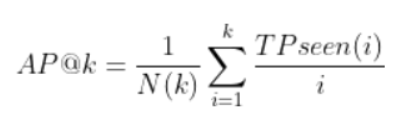

TP = true positives

N(k) = min(k,TPtotal)

TPseen(i) = {0 if i° FALSE, 1 if i° TRUE}

### Mean Average Precision at K

the mAP is the mean of AP@K obtained from different queries

### 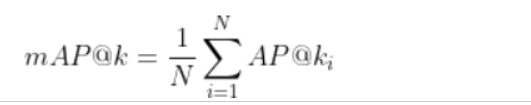



In [10]:
#compute AP@k
def compute_ap_at_k(ranked_relevance, k):
  #ranked_relevance is a boolean array of dim k. true if retrieved element is relevant for the query, false if not relevant 
  total_relevant_items = ranked_relevance.sum()

  # Precision@i for each query, i.e. the number of relevant items @i divided by i
  #cumsum [1,3,2]=>[1,4,6]
  prec_at_i = ranked_relevance.cumsum() / np.arange(1, k + 1) 

  # sum of prec_at_i only for relevant, divide for total number of relevant items 
  aps = (ranked_relevance * prec_at_i).sum() / total_relevant_items

  return aps

In [11]:
def show_images(res_ids, res_dists, ranked_relevance, path):
  #load images from images names(ids)
  imgs=[]
  for name in res_ids:
    for root, dirs, files in os.walk(path):
      if name in files:
        elem = str(os.path.join(root, name))
        img=np.array(load_img(elem, target_size=(80,80,3)))   
        imgs.append(img)

  for i in range(len(imgs)):
    # add a red/green flag
    color = (0, 255, 0) if ranked_relevance[i] else (255, 0, 0)
    flag = np.full((4, 80, 3), fill_value=color, dtype=imgs[i].dtype)
    imgs[i] = np.concatenate((imgs[i], flag), axis=0)

    # resize
    imgs[i] = Image.fromarray(imgs[i]).convert('RGBA')

    # draw score
    draw = ImageDraw.Draw(imgs[i])
    draw.text((3, 80 - 12), f'{res_dists[i]:.2f}', anchor='lt', fill=(255, 255, 255, 255))

    # pad the image with transparency
    imgs[i] = ImageOps.expand(imgs[i], 5, fill=(0, 0, 0, 0))
    imgs[i] = np.array(imgs[i])

  image = np.concatenate(imgs, axis=1)  # concatenate results horizontally
  display(Image.fromarray(image))

In [12]:
def evaluate_knn(queries, k, test_ids, test_features, vp_tree):
  aps=[]
  for query_index in queries:

    query_id = test_ids[query_index]
    query_features = test_features[query_index]
    #print(query_features)
    #perform the knn search
    res_nn, res_dists = vp_tree.knn_search(k, query_features)  #[img_id, img_features], distance(query,img)
    res_ids= [element[0] for element in res_nn]

    ranked_labels = retrieve_classes(res_ids, SETS_DIR) #retrieve the labels of topk results
    query_label = retrieve_classes([query_id], SETS_DIR)[0] #retrieve query label
    
    # ranked_relevance is if the retrieved image is relevant for the query
    ranked_relevance = np.array([label==query_label for label in ranked_labels])

    #compute ap@k
    ap_k = compute_ap_at_k(ranked_relevance, k) 
    aps.append(ap_k)  #aps maintain ap@k for each query

    x = min(k, 15) #don't show more than 15 result in colab
    show_images(res_ids[:x], res_dists[:x], ranked_relevance[:x], SETS_DIR)

  #calculate mAP
  mean=np.mean(aps)
  print('AP@', k ,'for each Query: ', aps)
  print('mAP@', k ,':', mean) 

In [13]:
#extract features with the fine tuned model and the relative image names
model_finetuned = keras.models.load_model(MODEL_PATH)
model_finetuned = keras.models.Model(inputs=model_finetuned.input, outputs=model_finetuned.get_layer('dense_hidden').output)
ft_test_features = model_finetuned.predict(test_set, batch_size=BATCH_SIZE, verbose=1)
ft_test_features = list(sklearn.preprocessing.normalize(ft_test_features))

ft_test_ids = ids_extractor(SETS_DIR) 

#the index creation needs theese files
np.save('/content/ft_ids.npy', ft_test_ids)
np.save('/content/ft_features.npy', ft_test_features)



#extract features with the pretrained model and the relative image names
model_pretrained = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg')

pt_test_features = model_pretrained.predict(test_set, batch_size=BATCH_SIZE, verbose=1)
pt_test_features = list(sklearn.preprocessing.normalize(pt_test_features))

pt_test_ids = ids_extractor(SETS_DIR) 

np.save('/content/pt_ids.npy', pt_test_ids)
np.save('/content/pt_features.npy', pt_test_features)



60/60 [==============================] - 42s 689ms/step


In [14]:
#build the index for features extracted with the fine tuned model
vp_tree_ft = vp("index_test_ft",height=10, disk_mode=True, leaves_path=INDEX_DIR)
vp_tree_ft.create_vptree('/content/ft_ids.npy', '/content/ft_features.npy')

#build the index for features extracted with the pretrained model
vp_tree_pt = vp("index_test_pt",height=10, disk_mode=True, leaves_path=INDEX_DIR)
vp_tree_pt.create_vptree('/content/pt_ids.npy', '/content/pt_features.npy')

#vp.save_vptree(INDEX_PATH_FT, vp_tree_ft)

Number of data: 15150
The max height of the tree is: 12
Tree is building
Building of the tree completed in: 387.01133823394775 s
Number of data: 15150
The max height of the tree is: 12
Tree is building
Building of the tree completed in: 315.3767685890198 s


In [15]:
def print_queries(queries):
  imgs=[]
  for index in queries:
    name = ft_test_ids[index]
    for root, dirs, files in os.walk(SETS_DIR):
      if name in files:
        elem = str(os.path.join(root, name))
        img=np.array(load_img(elem, target_size=(80,80,3)))   
        imgs.append(img)

  for i in range(len(imgs)):
    # resize
    imgs[i] = Image.fromarray(imgs[i]).convert('RGBA')
    # pad the image with transparency
    imgs[i] = ImageOps.expand(imgs[i], 2, fill=(0, 0, 0, 0))
    imgs[i] = np.array(imgs[i])

  image = np.concatenate(imgs, axis=1)  # concatenate results horizontally

  print('Queries:')
  queries_names = [ft_test_ids[i] for i in queries ]
  queries_labels = [retrieve_classes([i], SETS_DIR)[0] for i in queries_names ]
  print('-Names: ', queries_names)
  print('-Labels: ',queries_labels)
  display(Image.fromarray(image))

Queries:
-Names:  ['3141241.jpg', '1251079.jpg', '2262300.jpg', '2153561.jpg', '2543475.jpg']
-Labels:  ['escargots', 'french_fries', 'panna_cotta', 'sashimi', 'chicken_curry']


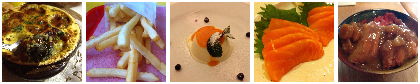

FINE TUNED MODEL:
Query answered in 1.6908221244812012  s


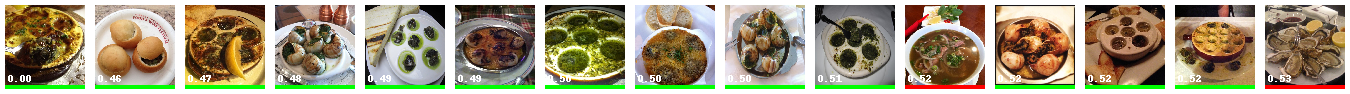

Query answered in 1.664438247680664  s


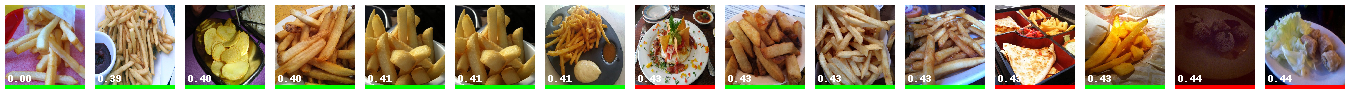

Query answered in 1.6771972179412842  s


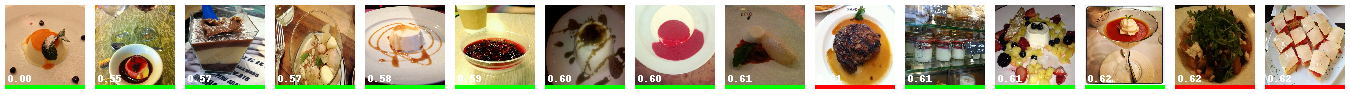

Query answered in 1.6292455196380615  s


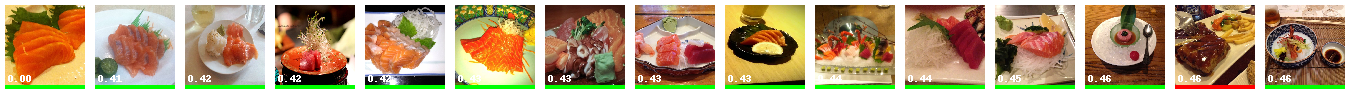

Query answered in 1.6436028480529785  s


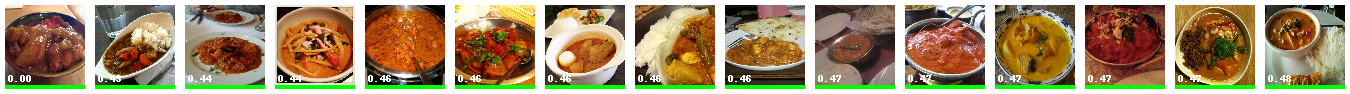

AP@ 20 for each Query:  [0.9560718716936467, 0.912369254676947, 0.9419057307215203, 0.9817801404957179, 1.0]
mAP@ 20 : 0.9584253995175664
MOBILE NET:
Query answered in 1.8069500923156738  s


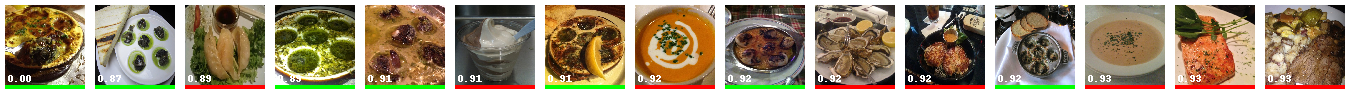

Query answered in 1.8039071559906006  s


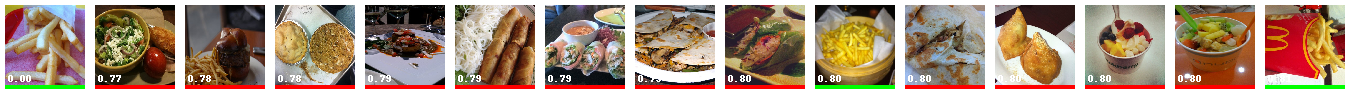

Query answered in 1.8717472553253174  s


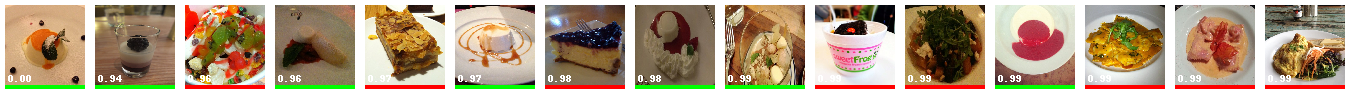

Query answered in 1.7877604961395264  s


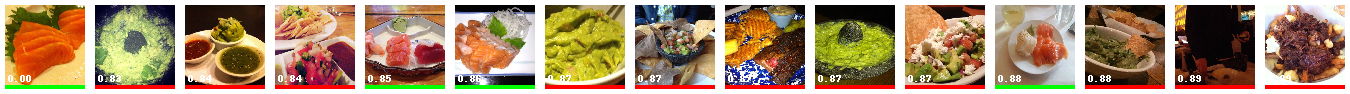

Query answered in 1.7476122379302979  s


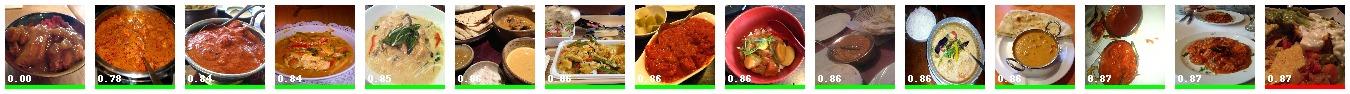

AP@ 20 for each Query:  [0.7176175733451275, 0.4088235294117647, 0.7170138888888888, 0.4992982456140351, 0.980351686598272]
mAP@ 20 : 0.6646209847716176


In [16]:
import numpy as np

K = 20
queries=[6546,613,951,12496,10264]

print_queries(queries)

print('FINE TUNED MODEL:')
#evaluate knnsearch on the finetuned model 
evaluate_knn(queries,K, ft_test_ids,ft_test_features, vp_tree_ft)

print('MOBILE NET:')
#evaluate knnsearch on the pretrained MobileNet model
evaluate_knn(queries,K,pt_test_ids,pt_test_features, vp_tree_pt)